In [2]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STATISTICAL TESTING
# ============================================================
from scipy import stats

# ============================================================
# SKLEARN: MODEL SELECTION & VALIDATION
# ============================================================
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split
)

# ============================================================
# SKLEARN: MODELS
# ============================================================
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# SKLEARN: METRICS & FEATURE IMPORTANCE
# ============================================================
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    mutual_info_score
)
from sklearn.inspection import permutation_importance

# ============================================================
# GRADIENT BOOSTING
# ============================================================
import xgboost as xgb

# ============================================================
# RULE / ILP / STRUCTURAL UTILITIES
# ============================================================
import itertools
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set

# ============================================================
# WARNINGS CONTROL
# ============================================================
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ============================================================
# CELL 2: LOAD & INSPECT DATA
# ============================================================

# Load dataset
path = "/content/sample_data/bank-full.csv"
df = pd.read_csv(path, sep=";")

print(f"Shape: {df.shape}")
df.head()

Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# ============================================================
# CELL 3: CHECK INPUT TYPES
# ============================================================
print("📌 COLUMN SCHEMA\n" + "-"*60)
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "n_unique": [df[c].nunique() for c in df.columns]
})
schema

📌 COLUMN SCHEMA
------------------------------------------------------------


,column,dtype,n_unique
age,age,int64,77
job,job,object,12
marital,marital,object,3
education,education,object,4
default,default,object,2
balance,balance,int64,7168
housing,housing,object,2
loan,loan,object,2
contact,contact,object,3
day,day,int64,31


In [6]:
# ============================================================
# CELL 4: EXAMINE CATAGORICAL COLUMNS
# ============================================================

categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)

📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     5207
married     27214
single      12790
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: count, dtype: int64

🔎 Column: default
----------------------------------------
default
no     44396
yes      815
Name: count, dtype: int64

🔎 Column: housing
----------------------------------------
housing
no     20081
yes    25130
Name: count, dtype: int64

🔎 Co

In [8]:
# ============================================================
# CELL 5: PREPROCESSING
# ============================================================

print("\n" + "="*80)
print("🔧 CLEAN PREPROCESSING")
print("="*80)

print(f"\nOriginal data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# --------------------------------------------------
# 1. CREATE CLEAN df_proc FRAME
# --------------------------------------------------
print("\n" + "="*40)
print("1. CREATING CLEAN df_proc")
print("="*40)

df_proc = df.copy()

print(f"\nInitial shape: {df_proc.shape}")
print(f"Columns: {list(df_proc.columns)}")

# --------------------------------------------------
# 1.1 Target encoding
# --------------------------------------------------
print(f"\n🔍 Target column 'y' before conversion:")
print(df_proc['y'].value_counts())

df_proc['y'] = df_proc['y'].map({'yes': 1, 'no': 0})
assert df_proc['y'].notna().all(), "❌ Unexpected values in target y"
df_proc['y'] = df_proc['y'].astype('int8')

print(f"\n✅ Target 'y' converted:")
print(df_proc['y'].value_counts())

# --------------------------------------------------
# 1.2 Binary categorical encoding
# --------------------------------------------------
binary_cols = ['default', 'housing', 'loan']
binary_map = {'no': 0, 'yes': 1}

print(f"\n🔍 Binary columns before conversion:")
for col in binary_cols:
    print(f"{col}:\n{df_proc[col].value_counts()}")

for col in binary_cols:
    df_proc[col] = df_proc[col].map(binary_map)
    assert df_proc[col].notna().all(), f"❌ Unexpected values in {col}"
    df_proc[col] = df_proc[col].astype('int8')

print(f"\n✅ Binary columns converted:")
for col in binary_cols:
    print(f"{col}: {df_proc[col].unique()}")

# --------------------------------------------------
# 1.3 Month → ordinal (DROP RAW MONTH)
# --------------------------------------------------
print(f"\n🔍 Month column before conversion:")
print(df_proc['month'].value_counts().sort_index())

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df_proc['month_ordinal'] = df_proc['month'].map(month_map)
assert df_proc['month_ordinal'].notna().all(), "❌ Unexpected month values"
df_proc['month_ordinal'] = df_proc['month_ordinal'].astype('int8')

# DROP raw month (no objects allowed)
df_proc.drop(columns=['month'], inplace=True)

print(f"\n✅ Month converted to ordinal and raw month dropped")

# --------------------------------------------------
# 1.4 POUTCOME - EXPLICIT MAPPING
# --------------------------------------------------
print(f"\n🔍 poutcome column before conversion:")
print(df_proc['poutcome'].value_counts())

poutcome_map = {
    'unknown': 0,
    'failure': 1,
    'other': 2,
    'success': 3
}

df_proc['poutcome'] = df_proc['poutcome'].map(poutcome_map)
assert df_proc['poutcome'].notna().all(), "❌ Unexpected poutcome values"
df_proc['poutcome'] = df_proc['poutcome'].astype('int8')

print(f"\n✅ poutcome converted:")
print(df_proc['poutcome'].value_counts())

# --------------------------------------------------
# 1.5 CONTACT - ORDINAL MAPPING
# --------------------------------------------------
print(f"\n🔍 contact column before conversion:")
print(df_proc['contact'].value_counts())

# Map contact as ORDINAL: cellular=0, telephone=1, unknown=2
contact_map = {
    'cellular': 0,
    'telephone': 1,
    'unknown': 2
}

df_proc['contact'] = df_proc['contact'].map(contact_map)
assert df_proc['contact'].notna().all(), "❌ Unexpected contact values"
df_proc['contact'] = df_proc['contact'].astype('int8')

print(f"\n✅ contact converted to ordinal (0=cellular, 1=telephone, 2=unknown):")
print(df_proc['contact'].value_counts().sort_index())

# --------------------------------------------------
# 1.6 Ordinal / Label encoding REMAINING categoricals
# --------------------------------------------------
categorical_cols = df_proc.select_dtypes(include=['object']).columns.tolist()

print(f"\n🔍 Ordinal-encoding remaining categoricals:")
print(categorical_cols)

for col in categorical_cols:
    df_proc[col] = df_proc[col].astype('category').cat.codes
    df_proc[col] = df_proc[col].astype('int16')

# --------------------------------------------------
# 1.7 HARD TYPE GUARANTEE
# --------------------------------------------------
non_numeric = df_proc.select_dtypes(exclude=['number']).columns.tolist()
assert len(non_numeric) == 0, f"❌ NON-NUMERIC COLUMNS REMAIN: {non_numeric}"

print("\n✅ ALL COLUMNS ARE NUMERIC")

# --------------------------------------------------
# 1.8 Sanity checks
# --------------------------------------------------
print(f"\n📊 Data types in df_proc:")
for dtype in df_proc.dtypes.unique():
    cols = df_proc.columns[df_proc.dtypes == dtype].tolist()
    print(f"{dtype}: {cols}")

print(f"\n🔍 Checking for null values:")
assert df_proc.isnull().sum().sum() == 0, "❌ Nulls detected"
print("✅ No null values")

print(f"\n🔍 Checking for duplicates:")
dup_count = df_proc.duplicated().sum()
print(f"Exact duplicate rows: {dup_count} ({dup_count/len(df_proc)*100:.2f}%)")

# --------------------------------------------------
# 1.9 Final confirmation
# --------------------------------------------------
print(f"\n✅ df_proc created successfully!")
print(f"Shape: {df_proc.shape}")
print(f"Memory usage: {df_proc.memory_usage().sum() / 1024**2:.2f} MB")


🔧 CLEAN PREPROCESSING

Original data shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

1. CREATING CLEAN df_proc

Initial shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

🔍 Target column 'y' before conversion:
y
no     39922
yes     5289
Name: count, dtype: int64

✅ Target 'y' converted:
y
0    39922
1     5289
Name: count, dtype: int64

🔍 Binary columns before conversion:
default:
default
no     44396
yes      815
Name: count, dtype: int64
housing:
housing
yes    25130
no     20081
Name: count, dtype: int64
loan:
loan
no     37967
yes     7244
Name: count, dtype: int64

✅ Binary columns converted:
default: [0 1]
housing: [1 0]
loan: [0 1]

🔍 Month column before conversion:
month
apr     2932



📊 ROBUST OUTLIER ANALYSIS (IQR / MEDIAN-BASED)

🔍 Inspecting 4 continuous features:
['duration', 'balance', 'campaign', 'previous']

📋 Robust distribution summary:


,feature,median,IQR,Q1,Q3,P95,P99,max
0,duration,180.0,216.0,103.0,319.0,751.0,1269.0,4918
1,balance,448.0,1356.0,72.0,1428.0,5768.0,13164.9,102127
2,campaign,2.0,2.0,1.0,3.0,8.0,16.0,63
3,previous,0.0,0.0,0.0,0.0,3.0,8.9,275



📦 Boxen plots (better than boxplots for heavy tails)


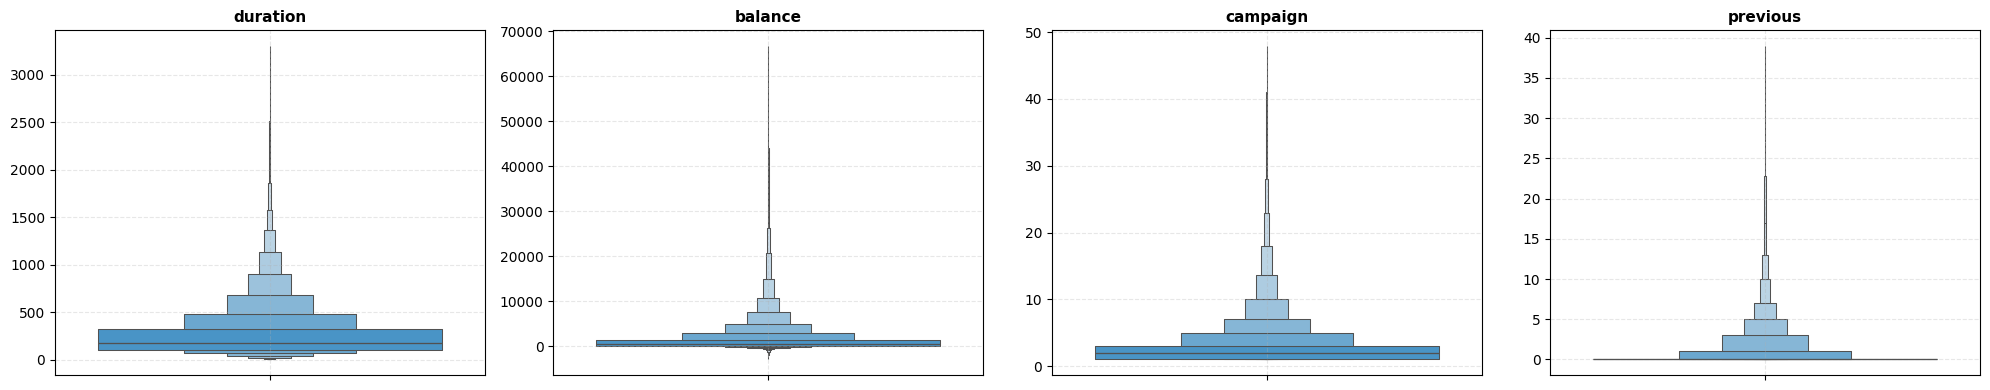


📈 Log-scale histograms (shape diagnostics only)


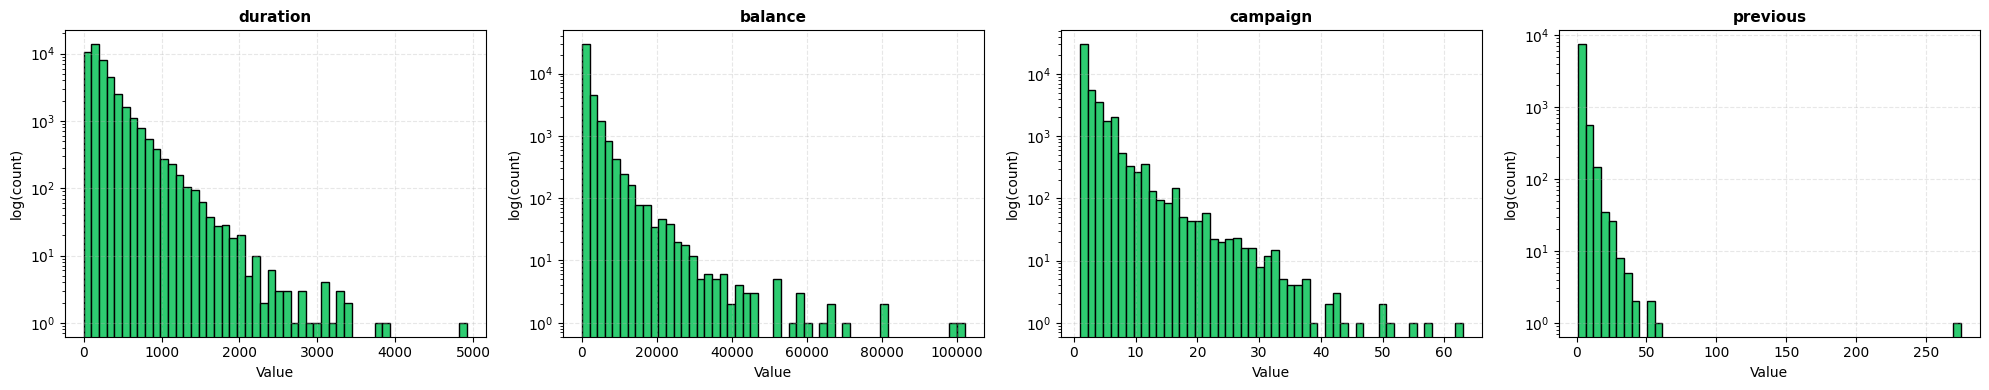


🚨 Extreme-tail flags (for decision-making, not trimming yet)
                duration: >P99 =  1.00% of rows
                 balance: >P99 =  1.00% of rows
                campaign: >P99 =  1.00% of rows
                previous: >P99 =  1.00% of rows


In [10]:
# ============================================================
# CELL 6: ROBUST OUTLIER ANALYSIS
# ============================================================

print("\n" + "="*80)
print("📊 ROBUST OUTLIER ANALYSIS (IQR / MEDIAN-BASED)")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --------------------------------------------------
# 1. Select CONTINUOUS / RISKY FEATURES ONLY
# --------------------------------------------------
# These are the ones that typically break rule coverage
outlier_features = [
    "duration",
    "balance",
    "campaign",
    "previous",
]

# Add ratio features if already created later in pipeline
optional_ratio_feats = [
    "duration_per_campaign",
    "previous_per_campaign"
]

for f in optional_ratio_feats:
    if f in df_proc.columns:
        outlier_features.append(f)

print(f"\n🔍 Inspecting {len(outlier_features)} continuous features:")
print(outlier_features)

# --------------------------------------------------
# 2. SUMMARY STATS
# --------------------------------------------------
summary = []

for col in outlier_features:
    s = df_proc[col]
    q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
    iqr = q3 - q1
    p95 = s.quantile(0.95)
    p99 = s.quantile(0.99)

    summary.append({
        "feature": col,
        "median": q2,
        "IQR": iqr,
        "Q1": q1,
        "Q3": q3,
        "P95": p95,
        "P99": p99,
        "max": s.max()
    })

summary_df = pd.DataFrame(summary)
print("\n📋 Robust distribution summary:")
display(summary_df)

# --------------------------------------------------
# 3. BOXEN PLOTS
# --------------------------------------------------
print("\n📦 Boxen plots (better than boxplots for heavy tails)")

n = len(outlier_features)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharey=False)

if n == 1:
    axes = [axes]

for ax, col in zip(axes, outlier_features):
    sns.boxenplot(
        y=df_proc[col],
        ax=ax,
        color="#3498db",
        showfliers=False
    )
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_ylabel("")
    ax.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. LOG-SCALE HISTOGRAMS (SHAPE INSPECTION)
# --------------------------------------------------
print("\n📈 Log-scale histograms (shape diagnostics only)")

fig, axes = plt.subplots(1, n, figsize=(5*n, 4))

if n == 1:
    axes = [axes]

for ax, col in zip(axes, outlier_features):
    vals = df_proc[col].values
    vals = vals[vals > 0]  # log-safe

    ax.hist(vals, bins=50, log=True, color="#2ecc71", edgecolor="black")
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("log(count)")
    ax.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. RULE-RELEVANT OUTLIER FLAGS (NO MUTATION)
# --------------------------------------------------
print("\n🚨 Extreme-tail flags (for decision-making, not trimming yet)")

for col in outlier_features:
    p99 = df_proc[col].quantile(0.99)
    pct = (df_proc[col] > p99).mean() * 100
    print(f"{col:>24}: >P99 = {pct:5.2f}% of rows")


In [11]:
"""
IMPORTANT NOTE ON DATA DISTRIBUTION & OUTLIERS:

We deliberately do NOT scale or alter the natural distributions of the data at this stage.
This includes not removing outliers, not applying normalization, and not transforming variables.

RATIONALE:
1. The observed skewness and extreme values represent real-world customer behavior where
   outliers often encode meaningful business signals rather than noise.

2. Overlapping spikes and distribution discontinuities may reflect:
   - Behavioral threshold effects (e.g., call duration regimes)
   - Temporal or seasonal campaign dynamics
   - Distinct customer segments with non-linear response patterns

3. Our feature engineering strategy (state-based binning and thresholds) is designed to
   capture these effects explicitly while preserving semantic interpretability.

4. The GLASS-BRW framework relies on discovering natural decision boundaries from data,
   rather than imposing artificial smoothness through scaling or normalization.

MODEL-SPECIFIC NOTE:
This choice is intentional for rule-based, threshold-driven models.
Scaling and outlier handling may be revisited for distance-based or linear models,
but are avoided here to preserve interpretability and behavioral signal fidelity.

NEXT STEPS:
- Evaluate whether specific extreme values degrade rule stability
- Apply targeted transformations only if they improve interpretability or robustness
- Continue prioritizing temporal and behavioral signal discovery over distribution smoothing

This approach reflects business reality, where extreme values often identify the most
valuable, risky, or responsive customer segments.
"""

'\nIMPORTANT NOTE ON DATA DISTRIBUTION & OUTLIERS:\n\nWe deliberately do NOT scale or alter the natural distributions of the data at this stage.\nThis includes not removing outliers, not applying normalization, and not transforming variables.\n\nRATIONALE:\n1. The observed skewness and extreme values represent real-world customer behavior where\n   outliers often encode meaningful business signals rather than noise.\n\n2. Overlapping spikes and distribution discontinuities may reflect:\n   - Behavioral threshold effects (e.g., call duration regimes)\n   - Temporal or seasonal campaign dynamics\n   - Distinct customer segments with non-linear response patterns\n\n3. Our feature engineering strategy (state-based binning and thresholds) is designed to\n   capture these effects explicitly while preserving semantic interpretability.\n\n4. The GLASS-BRW framework relies on discovering natural decision boundaries from data,\n   rather than imposing artificial smoothness through scaling or nor

In [12]:
# ============================================================
# CELL 7: GLASS-BRW STATE-BASED FEATURE ENGINEERING
# ============================================================

def engineer_features_bank(df_proc: pd.DataFrame) -> pd.DataFrame:
    """
    RF-aligned feature engineering for GLASS-BRW.

    INPUT  : df_proc (FULLY NUMERIC preprocessed frame)
    OUTPUT : df_eng  (Rule-safe binary states + target y)
    """

    print("🔍 Engineering RF-aligned features...")

    # =========================================================
    # DURATION REGIMES (RF-FAITHFUL)
    # =========================================================
    df_proc["dur_low"]  = (df_proc["duration"] <= 200).astype("int8")
    df_proc["dur_mid"]  = ((df_proc["duration"] > 200) & (df_proc["duration"] <= 300)).astype("int8")
    df_proc["dur_high"] = (df_proc["duration"] > 300).astype("int8")

    # =========================================================
    # PDAYS MEMORY STATES (COARSE, STABLE)
    # =========================================================
    df_proc["pdays_never"] = (df_proc["pdays"] <= 0).astype("int8")
    df_proc["pdays_1_5"]   = ((df_proc["pdays"] > 0) & (df_proc["pdays"] <= 5)).astype("int8")

    # =========================================================
    # MONTH REGIMES (MUTUALLY EXCLUSIVE)
    # =========================================================
    df_proc["month_early"]      = df_proc["month_ordinal"].isin([1, 2, 3, 4]).astype("int8")
    df_proc["month_late_spring"] = df_proc["month_ordinal"].isin([5, 6]).astype("int8")
    df_proc["month_summer"]     = df_proc["month_ordinal"].isin([7, 8]).astype("int8")
    df_proc["month_fall"]       = df_proc["month_ordinal"].isin([9, 10]).astype("int8")
    df_proc["month_year_end"]   = df_proc["month_ordinal"].isin([11, 12]).astype("int8")

    # =========================================================
    # SEMANTIC / BEHAVIORAL STATES
    # =========================================================
    df_proc["previous_ge1"] = (df_proc["previous"] >= 1).astype("int8")

    df_proc["engagement_score"] = (
        df_proc["previous_ge1"]
        + df_proc["pdays_1_5"]
        + df_proc["dur_high"]
        + (df_proc["poutcome"] == 3).astype("int8")
    ).astype("int8")

    df_proc["fatigue_score"] = (
        (df_proc["campaign"] >= 5).astype("int8")
        + (df_proc["campaign"] >= 8).astype("int8")
        + df_proc["dur_low"]
        + df_proc["pdays_never"]
    ).astype("int8")

    print("✅ RF-driven semantic states created")

    # =========================================================
    # BUILD df_eng (FINAL RULE INPUT)
    # =========================================================
    df_eng = pd.DataFrame(index=df_proc.index)

    # --- Target
    df_eng["y"] = df_proc["y"].astype("int8")

    # --- Duration
    df_eng["dur_low"]  = df_proc["dur_low"]
    df_eng["dur_mid"]  = df_proc["dur_mid"]
    df_eng["dur_high"] = df_proc["dur_high"]


    # --- Temporal opportunity
    df_eng["month_summer"]   = df_proc["month_summer"]
    df_eng["month_fall"]     = df_proc["month_fall"]
    df_eng["month_year_end"] = df_proc["month_year_end"]
    df_eng["month_early"] = df_proc["month_early"]
    df_eng["month_late_spring"] = df_proc["month_late_spring"]

    # --- Behavioral semantics
    df_eng["engagement_low"] = (df_proc["engagement_score"] <= 1).astype("int8")
    df_eng["fatigue_low"]    = (df_proc["fatigue_score"] <= 1).astype("int8")

    # --- Context + memory
    df_eng["housing"]          = df_proc["housing"].astype("int8")
    df_eng["poutcome_success"] = (df_proc["poutcome"] == 3).astype("int8")
    df_eng["pdays_never"]      = df_proc["pdays_never"]
    #df_eng["pdays_1_5"]        = df_proc["pdays_1_5"]

    print(f"✅ Engineered {df_eng.shape[1] - 1} RF-aligned features (+ y)")
    return df_eng


In [13]:
# ============================================================
# CELL 8: QUICK 10-FOLD RF SANITY CHECK
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import numpy as np
import pandas as pd

print("🔍 Running quick 10-fold RF sanity check (no tuning)...")

# ------------------------------------------------------------
# Prepare data
# ------------------------------------------------------------
df_eng = engineer_features_bank(df_proc)
X = df_eng.drop(columns=["y"])
y = df_eng["y"].values

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

# ------------------------------------------------------------
# 10-fold evaluation
# ------------------------------------------------------------
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        min_samples_leaf=50,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]

    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["auc"].append(roc_auc_score(y_test, y_prob))

    print(
        f"Fold {fold:2d} | "
        f"Acc: {metrics['accuracy'][-1]:.3f} | "
        f"Prec: {metrics['precision'][-1]:.3f} | "
        f"Rec: {metrics['recall'][-1]:.3f} | "
        f"F1: {metrics['f1'][-1]:.3f} | "
        f"AUC: {metrics['auc'][-1]:.3f}"
    )

# ------------------------------------------------------------
# Summary
# ------------------------------------------------------------
print("\n================= 10-FOLD SUMMARY =================")
for k, v in metrics.items():
    print(f"{k.upper():9s}: mean={np.mean(v):.4f} | std={np.std(v):.4f}")

# ------------------------------------------------------------
# Feature importance snapshot (mean)
# ------------------------------------------------------------
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("\n🔑 Top RF Feature Importances:")
display(importances.head(15))



🔍 Running quick 10-fold RF sanity check (no tuning)...
🔍 Engineering RF-aligned features...
✅ RF-driven semantic states created
✅ Engineered 13 RF-aligned features (+ y)
Fold  1 | Acc: 0.751 | Prec: 0.297 | Rec: 0.824 | F1: 0.437 | AUC: 0.861
Fold  2 | Acc: 0.752 | Prec: 0.301 | Rec: 0.850 | F1: 0.445 | AUC: 0.865
Fold  3 | Acc: 0.751 | Prec: 0.294 | Rec: 0.805 | F1: 0.431 | AUC: 0.854
Fold  4 | Acc: 0.754 | Prec: 0.303 | Rec: 0.849 | F1: 0.447 | AUC: 0.867
Fold  5 | Acc: 0.754 | Prec: 0.300 | Rec: 0.826 | F1: 0.440 | AUC: 0.858
Fold  6 | Acc: 0.742 | Prec: 0.286 | Rec: 0.803 | F1: 0.422 | AUC: 0.858
Fold  7 | Acc: 0.749 | Prec: 0.296 | Rec: 0.830 | F1: 0.436 | AUC: 0.859
Fold  8 | Acc: 0.755 | Prec: 0.305 | Rec: 0.854 | F1: 0.450 | AUC: 0.866
Fold  9 | Acc: 0.755 | Prec: 0.300 | Rec: 0.820 | F1: 0.439 | AUC: 0.859
Fold 10 | Acc: 0.753 | Prec: 0.300 | Rec: 0.832 | F1: 0.440 | AUC: 0.866

================= 10-FOLD SUMMARY =================
ACCURACY : mean=0.7517 | std=0.0036
PRECISION: 

,0
dur_high,0.238234
dur_low,0.230033
fatigue_low,0.110246
engagement_low,0.092418
poutcome_success,0.072170
housing,0.067402
month_early,0.039304
month_fall,0.037815
pdays_never,0.037367
dur_mid,0.030605


In [14]:
# ============================================================
# CELL 9: RULE DATA STRUCTURE
# ============================================================

@dataclass
class Rule:
    """
    Atomic rule representation for GLASS-BRW.

    A rule consists of:
    - segment: conjunction of (feature, value) conditions
    - predicted_class: 0 (NOT_SUBSCRIBE) or 1 (SUBSCRIBE)
    - complexity: number of conditions (k ≤ 3)
    """
    rule_id: int
    segment: Set[Tuple[str, str]]
    predicted_class: int  # 0 = NOT_SUBSCRIBE, 1 = SUBSCRIBE
    complexity: int

    # Metrics computed during validation
    precision: float = 0.0
    recall: float = 0.0
    coverage: float = 0.0
    stability: float = 0.0
    interpretability: float = 0.0
    boundary_ambiguity: float = 0.0
    rf_alignment: float = 0.0  # CHANGED: ebm_overlap -> rf_alignment

    def __hash__(self):
        return hash((self.rule_id, frozenset(self.segment), self.predicted_class))

    def __eq__(self, other):
        return self.rule_id == other.rule_id



In [15]:
# ============================================================
# CELL 10: GLASS-BRW: RF-BASED RULE EXTRACTION - PART 1
# Core Data Structures and Segment Builder
# ============================================================

from dataclasses import dataclass
from typing import Set, Tuple, List, Dict
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# ============================================================
# SEGMENT BUILDER - RF-ALIGNED FEATURES
# ============================================================

class BankSegmentBuilder:
    """
    RF-aligned binary segment builder for GLASS-BRW.
    Single-tier version (rule-safe).

    Uses only binary, interpretable state features.
    """

    SEGMENT_FEATURES = [
        # Duration intent
        "dur_low",
        "dur_mid",
        "dur_high",

        #   Temporal opportunity
        "month_early",
        "month_late_spring",
        "month_summer",
        "month_fall",
        "month_year_end",

        # Behavioral semantics
        "engagement_low",
        "fatigue_low",
        "poutcome_success",

        # Context
        "housing",

        # Memory
        "pdays_never",
       #"pdays_1_5"

    ]


    def assign_segments(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Extract binary segment features from input data.

        Args:
            X: DataFrame with engineered binary features

        Returns:
            Binary DataFrame used for rule generation
        """
        X = X.drop(columns=["y", "y_bin"], errors="ignore")

        # Filter to available columns
        cols = [c for c in self.SEGMENT_FEATURES if c in X.columns]

        if len(cols) == 0:
            raise ValueError("No valid segment features found in input")

        segments = X[cols].copy()

        # Enforce binary contract
        for col in segments.columns:
            vals = set(segments[col].dropna().unique())
            if not vals.issubset({0, 1}):
                raise ValueError(f"Non-binary segment feature: {col} -> {vals}")

        return segments.astype("int8")

In [16]:
# ============================================================
# CELL 11: GLASS-BRW: RF-BASED RULE EXTRACTION - PART 2
# Rule Generator with RF-Guided Feature Selection
# ============================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

class RuleGenerator:
    """
    Generates candidate rules using RF-guided feature importance
    and beam search over segment lattice.

    Key changes from EBM version:
    - Uses RF feature importance for initial feature ranking
    - Computes RF-alignment score for validation
    - Maintains class-conditional constraints from GLASS-BRW spec
    """

    def __init__(
        self,
        min_support=50,

        # GLOBAL bounds
        max_complexity=3,
        min_complexity=3,

        # CLASS-CONDITIONAL complexity
        min_complexity_subscribe=3,
        min_complexity_not_subscribe=3,

        # CLASS-CONDITIONAL coverage caps
        max_coverage_subscribe=0.05,
        max_coverage_not_subscribe=0.15,

        # CLASS-CONDITIONAL precision floors
        min_precision_subscribe=0.75,
        min_precision_not_subscribe=0.75,

        # CLASS-CONDITIONAL PRECISION CAPS
        max_precision_subscribe=0.95,
        max_precision_not_subscribe=0.80,

        # CLASS-CONDITIONAL recall floors
        min_recall_subscribe=0.25,
        min_recall_not_subscribe=0.32,

        # CLASS-CONDITIONAL AUC floors (rule-local AUC)
        min_auc_subscribe=0.50,
        min_auc_not_subscribe=0.50,

        # Beam search parameters
        mode="strict",
        beam_width=100,
        min_precision_gain=0.0,
        min_seed_precision_subscribe=0.60,
        min_seed_precision_not_subscribe=0.60,

        # Feature tier identification
        tier1_prefixes=("dur", "month", "pdays",
                        "fatigue", "engagement", "poutcome"),

        # RF-specific parameters
        rf_model=None,  # Pre-trained RF model
        feature_importance_threshold=0.01,  # Min importance for feature consideration
    ):
        # Support and complexity
        self.min_support = min_support
        self.max_complexity = max_complexity
        self.min_complexity = min_complexity

        # Class-conditional complexity
        self.min_complexity_subscribe = min_complexity_subscribe
        self.min_complexity_not_subscribe = min_complexity_not_subscribe

        # Class-conditional coverage
        self.max_coverage_subscribe = max_coverage_subscribe
        self.max_coverage_not_subscribe = max_coverage_not_subscribe

        # Class-conditional precision
        self.min_precision_subscribe = min_precision_subscribe
        self.min_precision_not_subscribe = min_precision_not_subscribe

        # Class-conditional minimum recall
        self.min_recall_subscribe = min_recall_subscribe
        self.min_recall_not_subscribe = min_recall_not_subscribe

        # Class-conditional max recall
        self.max_precision_subscribe = max_precision_subscribe
        self.max_precision_not_subscribe = max_precision_not_subscribe

        # Class-conditional AUC
        self.min_auc_subscribe = min_auc_subscribe
        self.min_auc_not_subscribe = min_auc_not_subscribe

        # Beam search
        self.mode = mode
        self.beam_width = beam_width
        self.min_precision_gain = min_precision_gain
        self.min_seed_precision_subscribe = min_seed_precision_subscribe
        self.min_seed_precision_not_subscribe = min_seed_precision_not_subscribe

        # Feature semantics
        self.tier1_prefixes = tier1_prefixes

        # RF-specific
        self.rf_model = rf_model
        self.feature_importance_threshold = feature_importance_threshold
        self.feature_importances_ = None

    def _compute_rf_feature_importance(self, segments_df, y):
        """
        Extract feature importance from RF model or train new one.

        Args:
            segments_df: Binary segment features
            y: Target labels

        Returns:
            Dict mapping feature names to importance scores
        """
        if self.rf_model is None:
            # Train RF for importance extraction
            print("Training RF for feature importance...")
            self.rf_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=8,
                min_samples_split=50,
                min_samples_leaf=25,
                random_state=42,
                n_jobs=-1
            )
            self.rf_model.fit(segments_df, y)

        # Extract importance scores
        importances = dict(zip(
            segments_df.columns,
            self.rf_model.feature_importances_
        ))

        self.feature_importances_ = importances

        # Log top features
        top_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\nTop 10 RF features by importance:")
        for feat, imp in top_features:
            print(f"  {feat}: {imp:.4f}")

        return importances

    def _compute_rule_mask(self, segment, segments_df):
        """Create boolean mask for samples matching rule segment."""
        mask = pd.Series(True, index=segments_df.index)
        for f, l in segment:
            mask &= (segments_df[f] == l)
        return mask

    def _compute_precision(self, mask, y, cls):
        """Compute precision for rule on given class."""
        if mask.sum() == 0:
            return 0.0
        return (y[mask] == cls).mean()

    def _compute_recall(self, mask, y, cls):
        """Compute recall for rule on given class."""
        total_class = (y == cls).sum()
        if total_class == 0:
            return 0.0
        true_positives = ((y == cls) & mask).sum()
        return true_positives / total_class

    def _compute_rule_auc(self, mask, y, cls):
        """
        Compute local AUC for rule predictions.

        Treats rule as binary classifier: 1 if matched, 0 otherwise.
        """
        if mask.sum() == 0 or mask.sum() == len(mask):
            return 0.5

        try:
            y_true = (y == cls).astype(int)
            y_score = mask.astype(int)
            return roc_auc_score(y_true, y_score)
        except:
            return 0.5

    def _has_tier1_feature(self, segment):
        """Check if segment contains Tier 1 behavioral feature."""
        feats = {f for f, _ in segment}
        return any(any(f.startswith(p) for p in self.tier1_prefixes) for f in feats)

    def _is_valid_semantic(self, segment):
        """Validate semantic composition of segment."""
        return self._has_tier1_feature(segment)

    def _score(self, p, r, c):
        """
        Compute beam search priority score.

        Emphasizes precision² × recall × coverage
        to favor high-precision, high-impact rules.
        """
        return (p ** 2) * r * c

    def _get_feature_order(self, segments_df, y):
        """
        Determine feature expansion order using RF importance.

        Returns features sorted by importance (descending).
        Features below threshold are excluded.
        """
        importances = self._compute_rf_feature_importance(segments_df, y)

        # Filter by threshold
        important_features = [
            f for f, imp in importances.items()
            if imp >= self.feature_importance_threshold
        ]

        # Sort by importance
        important_features.sort(key=lambda f: importances[f], reverse=True)

        print(f"\nUsing {len(important_features)}/{len(segments_df.columns)} features above threshold")

        return important_features

    def generate_candidates(self, segments_df, y):
        """
        Generate candidate rules via RF-guided beam search.

        Process:
        1. Compute RF feature importance
        2. Seed rules from top features
        3. Beam search expansion with precision/recall gates
        4. Return rules meeting complexity requirements

        Args:
            segments_df: Binary segment features (N × F)
            y: Target labels (N,)

        Returns:
            List of Rule objects passing all filters
        """
        # Get RF-ranked features
        features = self._get_feature_order(segments_df, y)
        N = len(segments_df)

        print(f"\nBeam search configuration:")
        print(f"  Beam width: {self.beam_width}")
        print(f"  Complexity: {self.min_complexity}–{self.max_complexity}")
        print(f"  Min support: {self.min_support} samples")

        rule_id = 0
        all_candidates = []
        current = {0: [], 1: []}

        # ============================================================
        # DEPTH 1: SEED RULES FROM TOP FEATURES
        # ============================================================
        print("\n" + "="*60)
        print("DEPTH 1: Seeding rules from RF-important features")
        print("="*60)

        for f in features:
            for l in (1, 0):  # Binary: presence (1) or absence (0)
                seg = {(f, l)}

                # Semantic validation
                if not self._is_valid_semantic(seg):
                    continue

                mask = self._compute_rule_mask(seg, segments_df)
                supp = mask.sum()
                if supp < self.min_support:
                    continue

                cov = supp / N

                # Generate rules for both classes
                for cls in (0, 1):
                    p = self._compute_precision(mask, y, cls)
                    r = self._compute_recall(mask, y, cls)

                    # Class-conditional seed filters
                    if cls == 1 and p < self.min_seed_precision_subscribe:
                        continue
                    if cls == 0 and p < self.min_seed_precision_not_subscribe:
                        continue
                    if cls == 1 and r < self.min_recall_subscribe:
                        continue
                    if cls == 0 and r < self.min_recall_not_subscribe:
                        continue

                    rule = Rule(
                        rule_id=rule_id,
                        segment=seg,
                        predicted_class=cls,
                        complexity=1,
                        interpretability=1.0
                    )

                    # Store metrics for beam scoring
                    rule._p, rule._r, rule._c = p, r, cov
                    rule._s = self._score(p, r, cov)

                    current[cls].append(rule)
                    rule_id += 1

        # Beam pruning
        for cls in (0, 1):
            current[cls] = sorted(current[cls], key=lambda r: r._s, reverse=True)[:self.beam_width]

        print(f"\nSeeds after beam prune:")
        print(f"  SUBSCRIBE: {len(current[1])} rules")
        print(f"  NOT_SUBSCRIBE: {len(current[0])} rules")

        # ============================================================
        # DEPTH 2+: BEAM SEARCH EXPANSION
        # ============================================================
        for depth in range(2, self.max_complexity + 1):
            print(f"\n{'='*60}")
            print(f"DEPTH {depth}: Expanding rules")
            print("="*60)

            next_rules = {0: [], 1: []}
            expansions = 0

            for cls in (0, 1):
                for parent in current[cls]:
                    used = {f for f, _ in parent.segment}

                    # Try adding each unused feature
                    for f in features:
                        if f in used:
                            continue

                        for l in (1, 0):
                            seg = parent.segment | {(f, l)}

                            # Semantic validation
                            if not self._is_valid_semantic(seg):
                                continue

                            mask = self._compute_rule_mask(seg, segments_df)
                            supp = mask.sum()
                            if supp < self.min_support:
                                continue

                            p = self._compute_precision(mask, y, cls)
                            r = self._compute_recall(mask, y, cls)

                            # Precision monotonicity check
                            if p < parent._p - self.min_precision_gain:
                                continue

                            # Class-conditional recall gates
                            if cls == 1 and r < self.min_recall_subscribe:
                                continue
                            if cls == 0 and r < self.min_recall_not_subscribe:
                                continue

                            cov = supp / N
                            rule = Rule(
                                rule_id=rule_id,
                                segment=seg,
                                predicted_class=cls,
                                complexity=depth,
                                interpretability=1.0 / depth
                            )

                            rule._p, rule._r, rule._c = p, r, cov
                            rule._s = self._score(p, r, cov)

                            next_rules[cls].append(rule)
                            rule_id += 1
                            expansions += 1

            if expansions == 0:
                print(f"No valid expansions — stopping early at depth {depth-1}")
                break

            # Beam pruning
            for cls in (0, 1):
                next_rules[cls] = sorted(next_rules[cls], key=lambda r: r._s, reverse=True)[:self.beam_width]

                # Add to candidates if complexity requirement met
                if depth >= self.min_complexity:
                    all_candidates.extend(next_rules[cls])

            print(f"\nAfter beam prune:")
            print(f"  SUBSCRIBE: {len(next_rules[1])} rules")
            print(f"  NOT_SUBSCRIBE: {len(next_rules[0])} rules")

            current = next_rules

        print(f"\n{'='*60}")
        print(f"✅ Generated {len(all_candidates)} candidate rules (k ≥ {self.min_complexity})")
        print("="*60)

        return all_candidates


In [17]:
# ============================================================
# CELL 12: GLASS-BRW: RF-BASED RULE EXTRACTION - PART 3
# Rule Evaluation and Validation Metrics
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score
from collections import defaultdict

class RuleEvaluator:
    """
    Compute validation-based quality metrics for candidate rules.

    Key changes from EBM version:
    - Replaced ebm_overlap with rf_alignment
    - Replaced boundary_ambiguity with rf_confidence_score
    - Uses RF predictions for complementarity metrics
    """

    def __init__(self, segment_builder, min_support=30):
        self.segment_builder = segment_builder
        self.min_support = min_support

    def _deduplicate_rules(self, rules):
        """
        Remove semantically identical rules.

        Identity = (predicted_class, segment conditions).
        Keeps the highest-precision version of each rule.
        """
        unique = {}

        for r in rules:
            key = (r.predicted_class, frozenset(r.segment))

            if key not in unique:
                unique[key] = r
            else:
                # Keep the better rule (prefer higher precision, then coverage)
                if (
                    r.precision > unique[key].precision or
                    (
                        r.precision == unique[key].precision and
                        r.coverage > unique[key].coverage
                    )
                ):
                    unique[key] = r

        return list(unique.values())


    def match_rule(self, rule, segments_df):
        """
        Create boolean mask for samples matching rule segment.

        Args:
            rule: Rule object with segment conditions
            segments_df: DataFrame of binary segment features

        Returns:
            Boolean Series indicating matches
        """
        mask = pd.Series(True, index=segments_df.index)
        for feature, level in rule.segment:
            if feature in segments_df.columns:
                mask &= (segments_df[feature] == level)
            else:
                return pd.Series(False, index=segments_df.index)
        return mask

    def evaluate_candidates(self, candidates, X_val, y_val, rf_model=None):
        """
        Evaluate candidate rules on validation data.

        Args:
            candidates: List of Rule objects from generation
            X_val: Validation features
            y_val: Validation labels
            rf_model: Optional RF model for alignment metrics

        Returns:
            List of evaluated Rule objects with computed metrics
        """
        segments_val = self.segment_builder.assign_segments(X_val)

        # Get RF predictions if model provided
        rf_proba = None
        if rf_model is not None:
            rf_proba = rf_model.predict_proba(X_val)[:, 1]

        evaluated_rules = []

        print(f"\nEvaluating {len(candidates)} candidate rules...")

        for rule in candidates:
            mask = self.match_rule(rule, segments_val)
            n_matches = mask.sum()
            rule.covered_idx = set(np.flatnonzero(mask.values))

            # Filter low-support rules
            if n_matches < self.min_support // 2:
                continue

            y_pred = np.full(n_matches, rule.predicted_class)
            y_true = y_val[mask]

            # ✅ CLASS-SPECIFIC PRECISION
            if rule.predicted_class == 1:
                rule.precision = precision_score(y_true, y_pred, zero_division=0.0)
            else:
                rule.precision = (y_true == 0).sum() / len(y_true) if len(y_true) > 0 else 0.0

            # ✅ CLASS-SPECIFIC RECALL
            if rule.predicted_class == 1:
                total_positives = (y_val == 1).sum()
                true_positives = ((y_val == 1) & mask).sum()
                rule.recall = true_positives / total_positives if total_positives > 0 else 0.0
            else:
                total_negatives = (y_val == 0).sum()
                true_negatives = ((y_val == 0) & mask).sum()
                rule.recall = true_negatives / total_negatives if total_negatives > 0 else 0.0

            # Coverage
            rule.coverage = n_matches / len(X_val)

            # Stability (bootstrap precision variance)
            if rule.predicted_class == 1:
                rule.stability = self._estimate_stability(rule, X_val, y_val)
            else:
                rule.stability = 1.0

            # RF-SPECIFIC METRICS
            if rf_proba is not None:
                # RF Alignment: How confident is RF in this segment?
                # Higher confidence = better alignment
                rf_conf_in_segment = np.abs(rf_proba[mask] - 0.5)
                rule.rf_confidence = rf_conf_in_segment.mean()

                # RF Overlap: What fraction of segment has RF agreeing?
                # (confidence > 0.20 threshold = RF is reasonably sure)
                rule.rf_alignment = (rf_conf_in_segment > 0.20).mean()
            else:
                rule.rf_confidence = 0.5
                rule.rf_alignment = 0.0

            evaluated_rules.append(rule)

        print(f"Evaluated {len(evaluated_rules)} rules "
              f"(filtered {len(candidates) - len(evaluated_rules)} low-coverage)")

        return evaluated_rules

    def _estimate_stability(self, rule, X, y, n_bootstrap=3):
        """
        Estimate rule precision stability via bootstrap sampling.

        High stability = low variance in precision across samples.

        Args:
            rule: Rule to evaluate
            X: Feature data
            y: Labels
            n_bootstrap: Number of bootstrap iterations

        Returns:
            Stability score in [0, 1] (higher = more stable)
        """
        precisions = []
        n = len(X)

        for _ in range(n_bootstrap):
            idx = np.random.choice(n, size=n, replace=True)
            X_sample = X.iloc[idx]
            y_sample = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]

            segments = self.segment_builder.assign_segments(X_sample)
            mask = self.match_rule(rule, segments)

            if mask.sum() < 10:
                continue

            y_pred = np.full(mask.sum(), rule.predicted_class)
            y_true = y_sample[mask]

            if rule.predicted_class == 1:
                prec = precision_score(y_true, y_pred, zero_division=0.0)
            else:
                prec = (y_true == 0).sum() / len(y_true) if len(y_true) > 0 else 0.0

            precisions.append(prec)

        if len(precisions) < 2:
            return 0.0

        mean_prec = np.mean(precisions)
        std_prec = np.std(precisions)

        if mean_prec > 0:
            stability = 1.0 - (std_prec / mean_prec)
            return max(0.0, stability)
        else:
            return 0.0

    def match_rule(self, rule, segments_df):
        """
        Create boolean mask for samples matching rule segment.

        Args:
            rule: Rule object with segment conditions
            segments_df: DataFrame of binary segment features

        Returns:
            Boolean Series indicating matches
        """
        mask = pd.Series(True, index=segments_df.index)
        for feature, level in rule.segment:
            if feature in segments_df.columns:
                mask &= (segments_df[feature] == level)
            else:
                return pd.Series(False, index=segments_df.index)
        return mask

    def evaluate_candidates(self, candidates, X_val, y_val, rf_model=None):
        """
        Evaluate candidate rules on validation data.

        Args:
            candidates: List of Rule objects from generation
            X_val: Validation features
            y_val: Validation labels
            rf_model: Optional RF model for alignment metrics

        Returns:
            List of evaluated Rule objects with computed metrics
        """
        segments_val = self.segment_builder.assign_segments(X_val)

        # Get RF predictions if model provided
        rf_proba = None
        if rf_model is not None:
            rf_proba = rf_model.predict_proba(X_val)[:, 1]

        evaluated_rules = []

        print(f"\nEvaluating {len(candidates)} candidate rules...")

        for rule in candidates:
            mask = self.match_rule(rule, segments_val)
            n_matches = mask.sum()
            rule.covered_idx = set(np.flatnonzero(mask.values))

            # Filter low-support rules
            if n_matches < self.min_support // 2:
                continue

            y_pred = np.full(n_matches, rule.predicted_class)
            y_true = y_val[mask]

            # ✅ CLASS-SPECIFIC PRECISION
            if rule.predicted_class == 1:
                rule.precision = precision_score(y_true, y_pred, zero_division=0.0)
            else:
                rule.precision = (y_true == 0).sum() / len(y_true) if len(y_true) > 0 else 0.0

            # ✅ CLASS-SPECIFIC RECALL
            if rule.predicted_class == 1:
                total_positives = (y_val == 1).sum()
                true_positives = ((y_val == 1) & mask).sum()
                rule.recall = true_positives / total_positives if total_positives > 0 else 0.0
            else:
                total_negatives = (y_val == 0).sum()
                true_negatives = ((y_val == 0) & mask).sum()
                rule.recall = true_negatives / total_negatives if total_negatives > 0 else 0.0

            # Coverage
            rule.coverage = n_matches / len(X_val)

            # Stability (bootstrap precision variance)
            if rule.predicted_class == 1:
                rule.stability = self._estimate_stability(rule, X_val, y_val)
            else:
                rule.stability = 1.0

            # RF-SPECIFIC METRICS
            if rf_proba is not None:
                # RF Alignment: How confident is RF in this segment?
                # Higher confidence = better alignment
                rf_conf_in_segment = np.abs(rf_proba[mask] - 0.5)
                rule.rf_confidence = rf_conf_in_segment.mean()

                # RF Overlap: What fraction of segment has RF agreeing?
                # (confidence > 0.20 threshold = RF is reasonably sure)
                rule.rf_alignment = (rf_conf_in_segment > 0.20).mean()
            else:
                rule.rf_confidence = 0.5
                rule.rf_alignment = 0.0

            evaluated_rules.append(rule)

        print(f"Evaluated {len(evaluated_rules)} rules "
              f"(filtered {len(candidates) - len(evaluated_rules)} low-coverage)")

        # 🔥 SEMANTIC DEDUPLICATION
        before = len(evaluated_rules)
        evaluated_rules = self._deduplicate_rules(evaluated_rules)
        after = len(evaluated_rules)

        if after < before:
            print(f"Deduplicated rules: {before} → {after}")

        return evaluated_rules


    def _estimate_stability(self, rule, X, y, n_bootstrap=3):
        """
        Estimate rule precision stability via bootstrap sampling.

        High stability = low variance in precision across samples.

        Args:
            rule: Rule to evaluate
            X: Feature data
            y: Labels
            n_bootstrap: Number of bootstrap iterations

        Returns:
            Stability score in [0, 1] (higher = more stable)
        """
        precisions = []
        n = len(X)

        for _ in range(n_bootstrap):
            idx = np.random.choice(n, size=n, replace=True)
            X_sample = X.iloc[idx]
            y_sample = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]

            segments = self.segment_builder.assign_segments(X_sample)
            mask = self.match_rule(rule, segments)

            if mask.sum() < 10:
                continue

            y_pred = np.full(mask.sum(), rule.predicted_class)
            y_true = y_sample[mask]

            if rule.predicted_class == 1:
                prec = precision_score(y_true, y_pred, zero_division=0.0)
            else:
                prec = (y_true == 0).sum() / len(y_true) if len(y_true) > 0 else 0.0

            precisions.append(prec)

        if len(precisions) < 2:
            return 0.0

        mean_prec = np.mean(precisions)
        std_prec = np.std(precisions)

        if mean_prec > 0:
            stability = 1.0 - (std_prec / mean_prec)
            return max(0.0, stability)
        else:
            return 0.0


In [18]:
# ============================================================
# CELL 13: ILP RULE SELECTOR
# ============================================================

class ILPRuleSelector:
    """
    Integer Linear Programming solver for optimal rule subset selection.

    Objective:
        max Σ x_r * (precision_r² * recall_r * coverage_r * interpretability_r
                     - λ₁ * rf_uncertainty_r - λ₂ * (1 - rf_alignment_r))

    Constraints:
        - Cardinality: min_rules ≤ Σ x_r ≤ max_rules
        - Precision gates: x_r = 0 if precision_r < threshold
        - Recall gates: x_r = 0 if recall_r < threshold
        - Class balance: min/max rules per class
        - Feature diversity: max uses per feature

    Changes from EBM version:
    - Uses rf_alignment instead of ebm_overlap
    - Uses rf_confidence instead of boundary_ambiguity
    """

    def __init__(
        self,
        min_rules=8,
        max_rules=15,
        min_precision_subscribe=0.50,
        min_precision_not_subscribe=0.50,
        min_recall_subscribe=0.10,
        min_recall_not_subscribe=0.20,
        min_subscribe_rules=3,
        max_subscribe_rules=5,
        min_not_subscribe_rules=3,
        max_not_subscribe_rules=5,
        max_feature_usage=10,
        lambda_rf_uncertainty=0.15,  # Penalty for RF uncertainty
        lambda_rf_misalignment=0.10,  # Penalty for RF disagreement
        recall_weight=1.0
    ):
        self.min_rules = min_rules
        self.max_rules = max_rules
        self.min_precision_subscribe = min_precision_subscribe
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.min_recall_not_subscribe = min_recall_not_subscribe
        self.min_subscribe_rules = min_subscribe_rules
        self.max_subscribe_rules = max_subscribe_rules
        self.min_not_subscribe_rules = min_not_subscribe_rules
        self.max_not_subscribe_rules = max_not_subscribe_rules
        self.max_feature_usage = max_feature_usage
        self.lambda_rf_uncertainty = lambda_rf_uncertainty
        self.lambda_rf_misalignment = lambda_rf_misalignment
        self.recall_weight = recall_weight

    def select_rules(self, candidates):
        """
        Select optimal rule subset via ILP optimization.

        Args:
            candidates: List of evaluated Rule objects

        Returns:
            List of selected Rule objects
        """
        from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus, PULP_CBC_CMD

        if not candidates:
            print("Warning: No candidates provided to ILP selector.")
            return []

        # ============================================================
        # DEBUG: Show candidates before gating
        # ============================================================
        print("\n" + "="*80)
        print("🔍 ILP DEBUG: CANDIDATES BEFORE GATING")
        print("="*80)

        subscribe_cands = [r for r in candidates if r.predicted_class == 1]
        not_subscribe_cands = [r for r in candidates if r.predicted_class == 0]

        print(f"\nTotal candidates: {len(candidates)}")
        print(f"  SUBSCRIBE candidates: {len(subscribe_cands)}")
        print(f"  NOT_SUBSCRIBE candidates: {len(not_subscribe_cands)}")

        print(f"\n📊 Top 10 SUBSCRIBE candidates:")
        print(f"{'Rule':<6} {'Segment':<50} {'Precision':<10} {'Recall':<10} {'Coverage':<10} {'RF_Align':<10}")
        print("-" * 100)
        for i, r in enumerate(sorted(subscribe_cands, key=lambda x: x.precision, reverse=True)[:10], 1):
            seg_str = ' AND '.join([f"{f}={l}" for f, l in list(r.segment)[:2]])
            if len(r.segment) > 2:
                seg_str += f" ... (+{len(r.segment)-2})"
            rf_align = getattr(r, 'rf_alignment', 0.0)
            print(f"{i:<6} {seg_str:<50} {r.precision:<10.3f} {r.recall:<10.3f} {r.coverage:<10.3f} {rf_align:<10.3f}")

        print(f"\n📊 Top 10 NOT_SUBSCRIBE candidates:")
        print(f"{'Rule':<6} {'Segment':<50} {'Precision':<10} {'Recall':<10} {'Coverage':<10} {'RF_Align':<10}")
        print("-" * 100)
        for i, r in enumerate(sorted(not_subscribe_cands, key=lambda x: x.precision, reverse=True)[:10], 1):
            seg_str = ' AND '.join([f"{f}={l}" for f, l in list(r.segment)[:2]])
            if len(r.segment) > 2:
                seg_str += f" ... (+{len(r.segment)-2})"
            rf_align = getattr(r, 'rf_alignment', 0.0)
            print(f"{i:<6} {seg_str:<50} {r.precision:<10.3f} {r.recall:<10.3f} {r.coverage:<10.3f} {rf_align:<10.3f}")

        # ============================================================
        # Setup ILP problem
        # ============================================================
        max_seen = -1
        for r in candidates:
            if hasattr(r, "covered_idx") and r.covered_idx and len(r.covered_idx) > 0:
                max_seen = max(max_seen, max(r.covered_idx))

        N = max_seen + 1
        if N <= 0:
            print("Warning: Could not infer validation size.")
            return []

        prob = LpProblem("GLASS_BRW_RF_Selection", LpMaximize)
        x = {r.rule_id: LpVariable(f"x_{r.rule_id}", cat='Binary') for r in candidates}

        # ============================================================
        # OBJECTIVE: RF-ALIGNED QUALITY
        # ============================================================
        objective_terms = []
        for r in candidates:
            # Base quality
            quality = (r.precision ** 2) * r.recall * r.coverage * r.interpretability

            # RF alignment bonus/penalty
            rf_uncertainty = 1.0 - getattr(r, 'rf_confidence', 0.5)
            rf_misalignment = 1.0 - getattr(r, 'rf_alignment', 0.0)

            # Penalize RF-uncertain or misaligned rules
            adjusted_quality = (
                quality
                - self.lambda_rf_uncertainty * rf_uncertainty
                - self.lambda_rf_misalignment * rf_misalignment
            )

            objective_terms.append(x[r.rule_id] * adjusted_quality)

        prob += lpSum(objective_terms), "RF_Aligned_Objective"

        # ============================================================
        # PRECISION/RECALL GATES
        # ============================================================
        print("\n" + "="*80)
        print("🔍 APPLYING PRECISION/RECALL GATES")
        print("="*80)
        print(f"\nGate thresholds:")
        print(f"  SUBSCRIBE:     precision ≥ {self.min_precision_subscribe:.3f}, recall ≥ {self.min_recall_subscribe:.3f}")
        print(f"  NOT_SUBSCRIBE: precision ≥ {self.min_precision_not_subscribe:.3f}, recall ≥ {self.min_recall_not_subscribe:.3f}")

        subscribe_valid = []
        subscribe_rejected = []
        not_subscribe_valid = []
        not_subscribe_rejected = []

        for r in candidates:
            if r.predicted_class == 1:
                if r.precision >= self.min_precision_subscribe and r.recall >= self.min_recall_subscribe:
                    subscribe_valid.append(r)
                else:
                    subscribe_rejected.append(r)
                    prob += (x[r.rule_id] == 0, f"Gate_Sub_{r.rule_id}")
            else:
                if r.precision >= self.min_precision_not_subscribe and r.recall >= self.min_recall_not_subscribe:
                    not_subscribe_valid.append(r)
                else:
                    not_subscribe_rejected.append(r)
                    prob += (x[r.rule_id] == 0, f"Gate_NotSub_{r.rule_id}")

        print(f"\n✅ PASSED GATES:")
        print(f"  SUBSCRIBE:     {len(subscribe_valid)}/{len(subscribe_cands)}")
        print(f"  NOT_SUBSCRIBE: {len(not_subscribe_valid)}/{len(not_subscribe_cands)}")

        print(f"\n❌ REJECTED BY GATES:")
        print(f"  SUBSCRIBE:     {len(subscribe_rejected)}/{len(subscribe_cands)}")
        print(f"  NOT_SUBSCRIBE: {len(not_subscribe_rejected)}/{len(not_subscribe_cands)}")

               # Show rejection reasons for top SUBSCRIBE rules
        if len(subscribe_rejected) > 0:
            print(f"\n❌ Top 5 REJECTED SUBSCRIBE rules:")
            for i, r in enumerate(
                sorted(subscribe_rejected, key=lambda x: x.precision, reverse=True)[:5], 1
            ):
                seg_str = ' AND '.join([f"{f}={l}" for f, l in list(r.segment)[:2]])
                if len(r.segment) > 2:
                    seg_str += f" ... (+{len(r.segment)-2})"

                fail_reasons = []
                if r.precision < self.min_precision_subscribe:
                    fail_reasons.append(
                        f"precision {r.precision:.3f} < {self.min_precision_subscribe:.3f}"
                    )
                if r.recall < self.min_recall_subscribe:
                    fail_reasons.append(
                        f"recall {r.recall:.3f} < {self.min_recall_subscribe:.3f}"
                    )

                print(f"  {i}. {seg_str}")
                print(f"     FAILED: {', '.join(fail_reasons)}")

        # ============================================================
        # BUILD VALID RULE SET (ONLY RULES THAT PASSED GATES)
        # ============================================================
        valid = subscribe_valid + not_subscribe_valid
        print(f"\nTotal valid after gates: {len(valid)}")

        if len(valid) == 0:
            print("⚠️ No rules passed gates. Returning empty selection.")
            return []

        # ============================================================
        # SETUP ILP OVER VALID RULES ONLY
        # ============================================================
        prob = LpProblem("GLASS_BRW_RF_Selection", LpMaximize)
        x = {r.rule_id: LpVariable(f"x_{r.rule_id}", cat="Binary") for r in valid}

        # ============================================================
        # OBJECTIVE
        # ============================================================
        prob += lpSum(
            x[r.rule_id]
            * (
                (r.precision ** 2)
                * r.recall
                * r.coverage
                * r.interpretability
                - self.lambda_rf_uncertainty * (1.0 - getattr(r, "rf_confidence", 0.5))
                - self.lambda_rf_misalignment * (1.0 - getattr(r, "rf_alignment", 0.0))
            )
            for r in valid
        )

        # ============================================================
        # CARDINALITY CONSTRAINTS (CLAMPED)
        # ============================================================
        actual_min_sub = min(
            self.min_subscribe_rules,
            len(subscribe_valid),
            self.max_subscribe_rules
        )
        actual_min_not_sub = min(
            self.min_not_subscribe_rules,
            len(not_subscribe_valid),
            self.max_not_subscribe_rules
        )

        max_possible = min(
            self.max_rules,
            self.max_subscribe_rules + self.max_not_subscribe_rules,
            len(valid)
        )
        actual_min_rules = min(self.min_rules, len(valid), max_possible)

        prob += lpSum(x[r.rule_id] for r in valid) >= actual_min_rules
        prob += lpSum(x[r.rule_id] for r in valid) <= min(self.max_rules, len(valid))

        if subscribe_valid:
            prob += lpSum(x[r.rule_id] for r in subscribe_valid) >= actual_min_sub
            prob += lpSum(x[r.rule_id] for r in subscribe_valid) <= min(
                self.max_subscribe_rules, len(subscribe_valid)
            )

        if not_subscribe_valid:
            prob += lpSum(x[r.rule_id] for r in not_subscribe_valid) >= actual_min_not_sub
            prob += lpSum(x[r.rule_id] for r in not_subscribe_valid) <= min(
                self.max_not_subscribe_rules, len(not_subscribe_valid)
            )

        # ============================================================
        # FEATURE DIVERSITY (VALID ONLY)
        # ============================================================
        feature_usage = defaultdict(list)
        for r in valid:
            for feature, _ in r.segment:
                feature_usage[feature].append(r.rule_id)

        for feature, rule_ids in feature_usage.items():
            prob += lpSum(x[rid] for rid in rule_ids) <= self.max_feature_usage

        # ============================================================
        # SOLVE ILP
        # ============================================================
        print("\n" + "=" * 80)
        print("Solving RF-aligned ILP...")
        solver = PULP_CBC_CMD(msg=0, timeLimit=300)
        prob.solve(solver)

        status = LpStatus[prob.status]
        print(f"ILP Status: {status}")
        print("=" * 80)

        # ============================================================
        # FALLBACK IF INFEASIBLE
        # ============================================================
        if status != "Optimal":
            print("\n⚠️ ILP FAILED - Using greedy fallback")

            subscribe_sorted = sorted(
                subscribe_valid,
                key=lambda r: (r.precision ** 2) * r.recall * r.coverage * getattr(r, "rf_alignment", 0.5),
                reverse=True
            )
            not_subscribe_sorted = sorted(
                not_subscribe_valid,
                key=lambda r: (r.precision ** 2) * r.recall * r.coverage * getattr(r, "rf_alignment", 0.5),
                reverse=True
            )

            selected_rules = (
                subscribe_sorted[:self.max_subscribe_rules]
                + not_subscribe_sorted[:self.max_not_subscribe_rules]
            )

            print(f"   Selected {len(subscribe_sorted[:self.max_subscribe_rules])} SUBSCRIBE rules")
            print(f"   Selected {len(not_subscribe_sorted[:self.max_not_subscribe_rules])} NOT_SUBSCRIBE rules")
            print(f"   Total: {len(selected_rules)} rules")

            return selected_rules

        # ============================================================
        # EXTRACT SOLUTION
        # ============================================================
        selected_rules = [
            r for r in valid
            if x[r.rule_id].varValue is not None and x[r.rule_id].varValue > 0.5
        ]

        print(f"\nSelected {len(selected_rules)} rules via ILP")
        return selected_rules

In [19]:
# ============================================================
# CELL 14: GLASS-BRW RF-BASED RULE EXTRACTION - PART 4
# Main Classifier with First-Match-Wins Inference
# ============================================================

import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score

class GLASS_BRW:
    """
    GLASS-BRW: Precision-Gated Rule Ensemble with Abstention.

    RF-powered version that extracts interpretable rules aligned with
    Random Forest decision patterns while maintaining strict precision
    guarantees through symbolic rule validation.

    Key design principles:
    1. RF-guided feature importance for rule generation
    2. Class-conditional precision/recall gates
    3. First-match-wins inference with explicit abstention
    4. Complexity-bounded rules (max 3 conditions)
    5. ILP optimization for ensemble complementarity

    Changes from EBM version:
    - Uses RF for feature importance and alignment
    - Replaces EBM complementarity with RF alignment metrics
    - Maintains all GLASS-BRW theoretical guarantees
    """

    def __init__(
        self,
        mode="strict",
        min_precision_subscribe=0.50,
        min_precision_not_subscribe=0.50,
        min_recall_subscribe=0.10,
        min_recall_not_subscribe=0.10,
        min_support=25,
        max_complexity=3,
        min_rules=8,
        max_rules=10,
        max_subscribe_rules=5,
        max_not_subscribe_rules=5,
        rf_model=None  # Pre-trained RF model (optional)
    ):
        """
        Initialize GLASS-BRW classifier.

        Args:
            mode: Segmentation mode ('strict', 'standard', 'permissive')
            min_precision_subscribe: Precision gate for SUBSCRIBE rules
            min_precision_not_subscribe: Precision gate for NOT_SUBSCRIBE rules
            min_recall_subscribe: Recall gate for SUBSCRIBE rules
            min_recall_not_subscribe: Recall gate for NOT_SUBSCRIBE rules
            min_support: Minimum samples for rule generation
            max_complexity: Maximum conditions per rule (k ≤ 3)
            min_rules: Minimum rules to select
            max_rules: Maximum rules to select
            max_subscribe_rules: Maximum SUBSCRIBE rules
            max_not_subscribe_rules: Maximum NOT_SUBSCRIBE rules
            rf_model: Optional pre-trained Random Forest
        """
        self.mode = mode
        self.min_precision_subscribe = min_precision_subscribe
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.min_recall_not_subscribe = min_recall_not_subscribe
        self.min_support = min_support
        self.max_complexity = max_complexity
        self.min_rules = min_rules
        self.max_rules = max_rules
        self.max_subscribe_rules = max_subscribe_rules
        self.max_not_subscribe_rules = max_not_subscribe_rules

        # Components (assume imported from previous parts)
        self.segment_builder = BankSegmentBuilder()

        self.rule_generator = RuleGenerator(
            min_support=min_support,
            max_complexity=max_complexity,
            mode=mode,
            rf_model=rf_model,
            min_precision_subscribe=min_precision_subscribe,
            min_precision_not_subscribe=min_precision_not_subscribe,
            min_recall_subscribe=min_recall_subscribe,
            min_recall_not_subscribe=min_recall_not_subscribe
        )

        self.rule_evaluator = RuleEvaluator(self.segment_builder, min_support)

        self.ilp_selector = ILPRuleSelector(
            min_rules=min_rules,
            max_rules=max_rules,
            min_precision_subscribe=min_precision_subscribe,
            min_precision_not_subscribe=min_precision_not_subscribe,
            min_recall_subscribe=min_recall_subscribe,
            min_recall_not_subscribe=min_recall_not_subscribe,
            min_subscribe_rules=3,
            max_subscribe_rules=max_subscribe_rules,
            min_not_subscribe_rules=3,
            max_not_subscribe_rules=max_not_subscribe_rules
        )

        # Fitted attributes
        self.rules = None
        self.rf_model = rf_model
        self.is_fitted = False

    def fit(self, X_train, y_train, X_val, y_val, rf_model=None):
        """
        Train GLASS-BRW using RF-guided rule generation and ILP optimization.

        Process:
        1. Train/use RF for feature importance
        2. Generate candidate rules via RF-guided beam search
        3. Evaluate rules on validation set
        4. Select optimal subset via ILP
        5. Order rules by precision (SUBSCRIBE first)

        Args:
            X_train: Training features (with engineered bank features)
            y_train: Training labels (0/1)
            X_val: Validation features
            y_val: Validation labels
            rf_model: Optional RF model (trains new one if None)

        Returns:
            self
        """
        print("="*80)
        print("GLASS-BRW Training Pipeline (RF-Powered)")
        print("="*80)
        print(f"Mode: {self.mode}")
        print(f"Max complexity: {self.max_complexity}")
        print(f"Precision gates: SUB ≥ {self.min_precision_subscribe:.2f}, NOT_SUB ≥ {self.min_precision_not_subscribe:.2f}")
        print(f"Recall gates: SUB ≥ {self.min_recall_subscribe:.2f}, NOT_SUB ≥ {self.min_recall_not_subscribe:.2f}")

        # Update RF model if provided
        if rf_model is not None:
            self.rf_model = rf_model
            self.rule_generator.rf_model = rf_model

        # Convert to pandas
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train)
        if not isinstance(X_val, pd.DataFrame):
            X_val = pd.DataFrame(X_val)
        if not isinstance(y_train, (pd.Series, np.ndarray)):
            y_train = np.array(y_train)
        if not isinstance(y_val, (pd.Series, np.ndarray)):
            y_val = np.array(y_val)

        # ============================================================
        # PHASE 1: Assign customer segments
        # ============================================================
        print("\n" + "="*80)
        print("PHASE 1: Assigning customer segments")
        print("="*80)
        segments_train = self.segment_builder.assign_segments(X_train)
        print(f"  Training samples: {len(segments_train)}")
        print(f"  Segment features: {len(segments_train.columns)}")
        print(f"  Feature tiers: {self.mode}")

        # ============================================================
        # PHASE 2: Generate candidate rules (RF-guided)
        # ============================================================
        print("\n" + "="*80)
        print("PHASE 2: Generating candidate rules (RF-guided)")
        print("="*80)
        candidates = self.rule_generator.generate_candidates(segments_train, y_train)

        print(f"\nCandidate summary:")
        sub_cands = [r for r in candidates if r.predicted_class == 1]
        not_sub_cands = [r for r in candidates if r.predicted_class == 0]
        print(f"  SUBSCRIBE: {len(sub_cands)}")
        print(f"  NOT_SUBSCRIBE: {len(not_sub_cands)}")

        # ============================================================
        # PHASE 3: Evaluate on validation
        # ============================================================
        print("\n" + "="*80)
        print("PHASE 3: Evaluating rule quality on validation set")
        print("="*80)
        evaluated_candidates = self.rule_evaluator.evaluate_candidates(
            candidates, X_val, y_val, rf_model=self.rf_model
        )

        print(f"\nEvaluated candidates: {len(evaluated_candidates)}")

        # ============================================================
        # PHASE 4: ILP selection
        # ============================================================
        print("\n" + "="*80)
        print("PHASE 4: Solving ILP for optimal rule subset")
        print("="*80)
        selected_rules = self.ilp_selector.select_rules(evaluated_candidates)

        if not selected_rules:
            print("\n⚠️  WARNING: No rules selected! Relaxing constraints...")
            # Fallback: take top rules by precision
            sub_rules = sorted([r for r in evaluated_candidates if r.predicted_class == 1],
                             key=lambda r: r.precision, reverse=True)[:5]
            not_sub_rules = sorted([r for r in evaluated_candidates if r.predicted_class == 0],
                                  key=lambda r: r.precision, reverse=True)[:5]
            selected_rules = sub_rules + not_sub_rules

        # ============================================================
        # PHASE 5: Order rules (SUBSCRIBE → NOT_SUBSCRIBE, precision-sorted)
        # ============================================================
        print("\n" + "="*80)
        print("PHASE 5: Ordering rules (SUBSCRIBE → NOT_SUBSCRIBE)")
        print("="*80)

        subscribe_rules = sorted(
            [r for r in selected_rules if r.predicted_class == 1],
            key=lambda r: r.precision,
            reverse=True
        )
        not_subscribe_rules = sorted(
            [r for r in selected_rules if r.predicted_class == 0],
            key=lambda r: r.precision,
            reverse=True
        )
        self.rules = subscribe_rules + not_subscribe_rules

        # ============================================================
        # Print final ruleset
        # ============================================================
        print("\n" + "="*80)
        print("✅ FINAL RULESET (ordered by precision)")
        print("="*80)

        for i, rule in enumerate(self.rules, 1):
            segment_str = ' AND '.join([f"{f}={l}" for f, l in rule.segment])
            class_str = "SUBSCRIBE" if rule.predicted_class == 1 else "NOT_SUB"
            rf_align = getattr(rule, 'rf_alignment', 0.0)

            print(f"\n{i}. [{class_str:9s}] {segment_str}")
            print(f"   Precision: {rule.precision:.1%}, Recall: {rule.recall:.1%}, "
                  f"Coverage: {rule.coverage:.1%}, Complexity: {rule.complexity}")
            print(f"   RF Alignment: {rf_align:.1%}")

        print("\n" + "="*80)
        print(f"Total rules: {len(self.rules)}")
        print(f"  SUBSCRIBE: {len(subscribe_rules)}")
        print(f"  NOT_SUBSCRIBE: {len(not_subscribe_rules)}")
        print("="*80)

        self.is_fitted = True
        return self

    def predict(self, X):
        """
        Predict using first-match-wins with explicit abstention.

        Process:
        1. Assign segments to samples
        2. For each sample, iterate through ordered rules
        3. First matching rule determines prediction
        4. No match → ABSTAIN (-1)

        Args:
            X: Features (DataFrame with engineered features)

        Returns:
            predictions: Array of {-1, 0, 1} where -1 = ABSTAIN
            explanations: List of human-readable explanations
            confidences: Array of rule precisions
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        n = len(X)
        predictions = np.full(n, -1, dtype=int)
        explanations = [None] * n
        confidences = np.zeros(n)

        # Assign segments
        segments = self.segment_builder.assign_segments(X)

        # First-match-wins
        for i in range(n):
            for rule in self.rules:
                # Check if sample matches rule segment
                matches = True
                for feature, level in rule.segment:
                    if feature not in segments.columns:
                        matches = False
                        break
                    if segments.iloc[i][feature] != level:
                        matches = False
                        break

                if not matches:
                    continue

                # Optional: enforce precision floor at execution
                if rule.predicted_class == 1 and rule.precision < self.min_precision_subscribe:
                    continue
                if rule.predicted_class == 0 and rule.precision < self.min_precision_not_subscribe:
                    continue

                # Match found - make prediction
                predictions[i] = rule.predicted_class
                confidences[i] = rule.precision
                explanations[i] = self._format_explanation(rule)
                break

            # No rule matched → abstain
            if predictions[i] == -1:
                explanations[i] = "ABSTAIN: No high-precision segment rule applies"
                confidences[i] = 0.0

        # Store for later access
        self.last_predictions = predictions
        self.last_explanations = explanations
        self.last_confidences = confidences

        return predictions, explanations, confidences

    def predict_proba(self, X):
        """
        Return probability estimates [P(Not_Subscribe), P(Subscribe)].

        Probabilistic encoding:
        - SUBSCRIBE (y=1): [1-p, p] where p = rule precision
        - NOT_SUBSCRIBE (y=0): [p, 1-p] where p = rule precision
        - ABSTAIN (y=-1): [0.5, 0.5] (maximum uncertainty)

        Args:
            X: Features

        Returns:
            probas: Array of shape (n_samples, 2)
        """
        predictions, _, confidences = self.predict(X)
        n = len(X)
        probas = np.zeros((n, 2))

        for i in range(n):
            if predictions[i] == -1:  # ABSTAIN
                probas[i] = [0.5, 0.5]
            elif predictions[i] == 1:  # SUBSCRIBE
                probas[i] = [1 - confidences[i], confidences[i]]
            else:  # NOT_SUBSCRIBE
                probas[i] = [confidences[i], 1 - confidences[i]]

        return probas

    def _format_explanation(self, rule):
        """
        Generate human-readable explanation for a rule.

        Args:
            rule: Rule object

        Returns:
            Human-readable string explanation
        """
        conditions = [f"{feat}={level}" for feat, level in rule.segment]
        segment_str = ' AND '.join(conditions)
        class_name = "SUBSCRIBE" if rule.predicted_class == 1 else "NOT_SUBSCRIBE"
        return f"Segment: {segment_str} → {class_name} ({rule.precision:.1%} precision)"

    def explain_prediction(self, X, sample_idx=0):
        """
        Get explanation for a specific prediction.

        Args:
            X: Features (must call predict first)
            sample_idx: Index of sample to explain

        Returns:
            Human-readable explanation string
        """
        if not hasattr(self, 'last_explanations'):
            self.predict(X)
        if sample_idx < len(self.last_explanations):
            return self.last_explanations[sample_idx]
        return "No explanation available"

    def get_coverage_stats(self, X, y):
        """
        Compute coverage and performance statistics.

        Args:
            X: Features
            y: True labels

        Returns:
            Dictionary of coverage and performance metrics
        """
        predictions, _, confidences = self.predict(X)

        covered = (predictions != -1)
        coverage_rate = covered.mean()
        abstention_rate = 1 - coverage_rate

        # Performance on covered samples
        if covered.sum() > 0:
            covered_precision = precision_score(y[covered], predictions[covered])
            covered_recall = recall_score(y[covered], predictions[covered])
        else:
            covered_precision = 0.0
            covered_recall = 0.0

        # Class-specific coverage
        subscribe_covered = covered & (predictions == 1)
        not_subscribe_covered = covered & (predictions == 0)

        stats = {
            'coverage_rate': coverage_rate,
            'abstention_rate': abstention_rate,
            'covered_precision': covered_precision,
            'covered_recall': covered_recall,
            'subscribe_coverage': subscribe_covered.mean(),
            'not_subscribe_coverage': not_subscribe_covered.mean(),
            'avg_confidence': confidences[covered].mean() if covered.sum() > 0 else 0.0,
            'n_samples': len(X),
            'n_covered': covered.sum(),
            'n_abstained': (~covered).sum()
        }

        return stats

    def get_rule_summary(self):
        """
        Get summary of selected rules.

        Returns:
            DataFrame with rule statistics
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")

        summary = []
        for i, rule in enumerate(self.rules, 1):
            segment_str = ' AND '.join([f"{f}={l}" for f, l in rule.segment])
            class_name = "SUBSCRIBE" if rule.predicted_class == 1 else "NOT_SUBSCRIBE"
            rf_align = getattr(rule, 'rf_alignment', 0.0)

            summary.append({
                'rule_id': i,
                'class': class_name,
                'segment': segment_str,
                'precision': rule.precision,
                'recall': rule.recall,
                'coverage': rule.coverage,
                'complexity': rule.complexity,
                'rf_alignment': rf_align,
                'interpretability': rule.interpretability
            })

        return pd.DataFrame(summary)

In [20]:
# ============================================================
# CELL 15: COMPLETE GLASS-BRW PIPELINE (RF-POWERED)
# ENGINEER → SPLIT → TRAIN RF → TRAIN GLASS-BRW → TEST
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# 1. FEATURE ENGINEERING
# ============================================================
print("\n" + "="*80)
print("🔍 STEP 1: FEATURE ENGINEERING")
print("="*80)

df_eng = engineer_features_bank(df_proc)

# RF-aligned feature set (matches segment builder tiers)
top_15_features = [
        # Duration intent
        "dur_low",
        "dur_mid",
        "dur_high",

        #   Temporal opportunity
        "month_early",
        "month_late_spring",
        "month_summer",
        "month_fall",
        "month_year_end",

        # Behavioral semantics
        "engagement_low",
        "fatigue_low",
        "poutcome_success",

        # Context
        "housing",

        # Memory
        "pdays_never"
       # "pdays_1_5"



]

available_features = [f for f in top_15_features if f in df_eng.columns]
missing_features = [f for f in top_15_features if f not in df_eng.columns]

print(f"\n✅ Feature Engineering Complete:")
print(f"   Available: {len(available_features)}/{len(top_15_features)}")
if missing_features:
    print(f"   ⚠️  Missing: {missing_features}")
    raise ValueError(f"Critical features missing: {missing_features}")

y_clean = df_eng['y'].copy()
X_clean = df_eng[available_features].copy()

print(f"\n📊 Dataset Summary:")
print(f"   Features: {X_clean.shape[1]}")
print(f"   Samples: {X_clean.shape[0]:,}")
print(f"   Positive rate: {y_clean.mean():.2%}")
print(f"   Class balance: {(~y_clean).sum():,} NOT_SUB / {y_clean.sum():,} SUB")

# ============================================================
# 2. SAFE 70/15/15 SPLIT
# ============================================================
print("\n" + "="*80)
print("📊 STEP 2: STRATIFIED 70/15/15 TRAIN/VAL/TEST SPLIT")
print("="*80)

# First split: 85% temp, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.15,
    random_state=42,
    stratify=y_clean
)

# Second split: 70% train, 15% val (from 85% temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15/0.85,  # ~17.6% of temp = 15% of total
    random_state=42,
    stratify=y_temp
)

print(f"\n✅ Split Complete:")
print(f"   Train: {len(X_train):5,} ({len(X_train)/len(X_clean):5.1%}) | Pos: {y_train.mean():.2%}")
print(f"   Val:   {len(X_val):5,} ({len(X_val)/len(X_clean):5.1%}) | Pos: {y_val.mean():.2%}")
print(f"   Test:  {len(X_test):5,} ({len(X_test)/len(X_clean):5.1%}) | Pos: {y_test.mean():.2%}")

# Validate split ratios
assert 0.68 <= len(X_train)/len(X_clean) <= 0.72, "Train split ratio off"
assert 0.13 <= len(X_val)/len(X_clean) <= 0.17, "Val split ratio off"
assert 0.13 <= len(X_test)/len(X_clean) <= 0.17, "Test split ratio off"

# ============================================================
# 3. TRAIN RANDOM FOREST (for feature importance)
# ============================================================
print("\n" + "="*80)
print("🌲 STEP 3: TRAINING RANDOM FOREST")
print("="*80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=25,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print("Training RF on training set...")
rf_model.fit(X_train, y_train)

# Evaluate RF on validation
rf_val_pred = rf_model.predict(X_val)
rf_val_proba = rf_model.predict_proba(X_val)[:, 1]

print(f"\n📊 RF Performance on Validation:")
print(f"   Accuracy:  {accuracy_score(y_val, rf_val_pred):.3f}")
print(f"   Precision: {precision_score(y_val, rf_val_pred, zero_division=0):.3f}")
print(f"   Recall:    {recall_score(y_val, rf_val_pred, zero_division=0):.3f}")
print(f"   F1 Score:  {f1_score(y_val, rf_val_pred, zero_division=0):.3f}")
print(f"   ROC-AUC:   {roc_auc_score(y_val, rf_val_proba):.3f}")

# Show top RF features
print(f"\n🔍 Top 10 RF Features by Importance:")
feature_importances = sorted(
    zip(X_train.columns, rf_model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
)
for i, (feat, imp) in enumerate(feature_importances[:10], 1):
    print(f"   {i:2d}. {feat:25s} {imp:.4f}")

# ============================================================
# 4. TRAIN GLASS-BRW (RF-GUIDED)
# ============================================================
print("\n" + "="*80)
print("🚀 STEP 4: TRAINING GLASS-BRW (RF-GUIDED)")
print("="*80)

glass = GLASS_BRW(
    mode="strict",  # Use Tier 1 + 2 + 3 features
    min_precision_subscribe=0.10,
    min_precision_not_subscribe=0.10,
    min_recall_subscribe=0.05,
    min_recall_not_subscribe=0.50,
    min_support=25,
    max_complexity=3,
    min_rules=8,
    max_rules=10,
    max_subscribe_rules=5,
    max_not_subscribe_rules=3,
    rf_model=rf_model  # Pass trained RF for alignment
)

print("\nFitting GLASS-BRW with RF guidance...")
glass.fit(X_train, y_train, X_val, y_val, rf_model=rf_model)

# ============================================================
# 5. EVALUATE ON TEST SET
# ============================================================
print("\n" + "="*80)
print("📊 STEP 5: EVALUATION ON HELD-OUT TEST SET")
print("="*80)

predictions, explanations, confidences = glass.predict(X_test)
probas = glass.predict_proba(X_test)

covered = (predictions != -1)
preds_for_metrics = predictions.copy()
preds_for_metrics[preds_for_metrics == -1] = 0  # Abstain → NOT_SUBSCRIBE

print(f"\n📈 Coverage Analysis:")
print(f"   Covered:   {covered.sum():5,} ({covered.mean():.1%})")
print(f"   Abstained: {(~covered).sum():5,} ({(~covered).mean():.1%})")

print(f"\n📊 Overall Performance (abstain → NOT_SUBSCRIBE):")
print(f"   Accuracy:  {accuracy_score(y_test, preds_for_metrics):.3f}")
print(f"   Precision: {precision_score(y_test, preds_for_metrics, zero_division=0):.3f}")
print(f"   Recall:    {recall_score(y_test, preds_for_metrics, zero_division=0):.3f}")
print(f"   F1 Score:  {f1_score(y_test, preds_for_metrics, zero_division=0):.3f}")

if covered.sum() > 0:
    print(f"\n📊 Performance on Covered Cases Only:")
    print(f"   Samples:   {covered.sum():,}")
    print(f"   Accuracy:  {accuracy_score(y_test[covered], predictions[covered]):.3f}")
    print(f"   Precision: {precision_score(y_test[covered], predictions[covered], zero_division=0):.3f}")
    print(f"   Recall:    {recall_score(y_test[covered], predictions[covered], zero_division=0):.3f}")
    print(f"   F1 Score:  {f1_score(y_test[covered], predictions[covered], zero_division=0):.3f}")
    print(f"   Avg Confidence: {confidences[covered].mean():.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test[covered], predictions[covered])
    print(f"\n📊 Confusion Matrix (Covered Cases):")
    print(f"                Pred NOT_SUB  Pred SUBSCRIBE")
    print(f"Actual NOT_SUB      {cm[0,0]:5,}          {cm[0,1]:5,}")
    print(f"Actual SUBSCRIBE    {cm[1,0]:5,}          {cm[1,1]:5,}")

    # Detailed metrics by class
    print(f"\n📊 Classification Report (Covered Cases):")
    print(classification_report(
        y_test[covered],
        predictions[covered],
        target_names=['NOT_SUBSCRIBE', 'SUBSCRIBE'],
        zero_division=0
    ))

    # Precision by confidence bucket
    print(f"\n📊 Precision by Confidence Bucket:")
    for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        high_conf = covered & (confidences >= threshold)
        if high_conf.sum() > 0:
            prec = precision_score(y_test[high_conf], predictions[high_conf], zero_division=0)
            print(f"   Confidence ≥ {threshold:.1f}: {prec:.3f} ({high_conf.sum():,} samples)")

# ============================================================
# 6. COMPARE WITH RF BASELINE
# ============================================================
print("\n" + "="*80)
print("📊 STEP 6: COMPARISON WITH RF BASELINE")
print("="*80)

rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"\n📊 Random Forest (Test Set):")
print(f"   Accuracy:  {accuracy_score(y_test, rf_test_pred):.3f}")
print(f"   Precision: {precision_score(y_test, rf_test_pred, zero_division=0):.3f}")
print(f"   Recall:    {recall_score(y_test, rf_test_pred, zero_division=0):.3f}")
print(f"   F1 Score:  {f1_score(y_test, rf_test_pred, zero_division=0):.3f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test, rf_test_proba):.3f}")

print(f"\n📊 GLASS-BRW vs RF (Covered Cases):")
if covered.sum() > 0:
    glass_prec = precision_score(y_test[covered], predictions[covered], zero_division=0)
    rf_prec = precision_score(y_test[covered], rf_test_pred[covered], zero_division=0)
    glass_rec = recall_score(y_test[covered], predictions[covered], zero_division=0)
    rf_rec = recall_score(y_test[covered], rf_test_pred[covered], zero_division=0)

    print(f"   Precision: GLASS-BRW={glass_prec:.3f} | RF={rf_prec:.3f} | Δ={glass_prec-rf_prec:+.3f}")
    print(f"   Recall:    GLASS-BRW={glass_rec:.3f} | RF={rf_rec:.3f} | Δ={glass_rec-rf_rec:+.3f}")
    print(f"   Coverage:  GLASS-BRW={covered.mean():.1%} | RF=100.0%")

# ============================================================
# 7. RULE ANALYSIS
# ============================================================
print("\n" + "="*80)
print("🔍 STEP 7: RULE ANALYSIS & INTERPRETABILITY")
print("="*80)

subscribe_rules = [r for r in glass.rules if r.predicted_class == 1]
not_subscribe_rules = [r for r in glass.rules if r.predicted_class == 0]

print(f"\n📋 Ruleset Summary:")
print(f"   Total Rules: {len(glass.rules)}")
print(f"   SUBSCRIBE: {len(subscribe_rules)}")
print(f"   NOT_SUBSCRIBE: {len(not_subscribe_rules)}")
print(f"   Avg Complexity: {np.mean([r.complexity for r in glass.rules]):.2f}")
print(f"   Avg Precision: {np.mean([r.precision for r in glass.rules]):.3f}")
print(f"   Avg RF Alignment: {np.mean([getattr(r, 'rf_alignment', 0) for r in glass.rules]):.3f}")

if subscribe_rules:
    print(f"\n🔍 Top {min(5, len(subscribe_rules))} SUBSCRIBE Rules:")
    for i, r in enumerate(subscribe_rules[:5], 1):
        seg = ' AND '.join([f"{f}={l}" for f, l in r.segment])
        rf_align = getattr(r, 'rf_alignment', 0.0)
        print(f"\n  {i}. {seg}")
        print(f"     Precision: {r.precision:.1%} | Recall: {r.recall:.1%} | Coverage: {r.coverage:.1%}")
        print(f"     Complexity: {r.complexity} | RF Alignment: {rf_align:.1%}")

if not_subscribe_rules:
    print(f"\n🔍 Top {min(5, len(not_subscribe_rules))} NOT_SUBSCRIBE Rules:")
    for i, r in enumerate(not_subscribe_rules[:5], 1):
        seg = ' AND '.join([f"{f}={l}" for f, l in r.segment])
        rf_align = getattr(r, 'rf_alignment', 0.0)
        print(f"\n  {i}. {seg}")
        print(f"     Precision: {r.precision:.1%} | Recall: {r.recall:.1%} | Coverage: {r.coverage:.1%}")
        print(f"     Complexity: {r.complexity} | RF Alignment: {rf_align:.1%}")

# ============================================================
# 8. FEATURE USAGE ANALYSIS
# ============================================================
print("\n" + "="*80)
print("📊 STEP 8: FEATURE USAGE ANALYSIS")
print("="*80)

feature_usage = {}
feature_by_tier = {
    'Tier 1 (Behavioral)': [],
    'Tier 2 (Temporal)': [],
    'Tier 3 (Contextual)': []
}

tier1 = ['duration', 'engagement', 'fatigue', 'poutcome']
tier2 = ['month', 'day']
tier3 = ['housing', 'contact', 'age']

for r in glass.rules:
    for f, _ in r.segment:
        feature_usage[f] = feature_usage.get(f, 0) + 1

        # Categorize by tier
        if any(t in f for t in tier1):
            feature_by_tier['Tier 1 (Behavioral)'].append(f)
        elif any(t in f for t in tier2):
            feature_by_tier['Tier 2 (Temporal)'].append(f)
        elif any(t in f for t in tier3):
            feature_by_tier['Tier 3 (Contextual)'].append(f)

print(f"\n📊 Feature Usage Across All Rules:")
for f, cnt in sorted(feature_usage.items(), key=lambda x: x[1], reverse=True):
    pct = cnt / len(glass.rules) * 100
    print(f"   {f:25s}: {cnt:2d} rules ({pct:5.1f}%)")

print(f"\n📊 Usage by Feature Tier:")
for tier, features in feature_by_tier.items():
    if features:
        unique_features = set(features)
        print(f"   {tier:25s}: {len(unique_features)} unique features, {len(features)} total uses")

unused = set(available_features) - set(feature_usage.keys())
if unused:
    print(f"\n⚠️  Unused Features: {', '.join(sorted(unused))}")
else:
    print(f"\n✅ All features used at least once")

# ============================================================
# 9. SAMPLE EXPLANATIONS
# ============================================================
print("\n" + "="*80)
print("🔍 STEP 9: SAMPLE EXPLANATIONS")
print("="*80)

# Show 5 random covered predictions
covered_indices = np.where(covered)[0]
if len(covered_indices) > 0:
    sample_indices = np.random.choice(covered_indices, min(5, len(covered_indices)), replace=False)

    print("\n📝 Sample Predictions (Covered Cases):")
    for idx in sample_indices:
        actual = "SUBSCRIBE" if y_test.iloc[idx] == 1 else "NOT_SUBSCRIBE"
        predicted = "SUBSCRIBE" if predictions[idx] == 1 else "NOT_SUBSCRIBE"
        correct = "✓" if predictions[idx] == y_test.iloc[idx] else "✗"

        print(f"\n  Sample {idx} {correct}:")
        print(f"    Actual: {actual}")
        print(f"    Predicted: {predicted} (confidence: {confidences[idx]:.1%})")
        print(f"    Explanation: {explanations[idx]}")

# Show abstention examples
abstained_indices = np.where(~covered)[0]
if len(abstained_indices) > 0:
    print(f"\n📝 Sample Abstentions (first 3):")
    for idx in abstained_indices[:3]:
        actual = "SUBSCRIBE" if y_test.iloc[idx] == 1 else "NOT_SUBSCRIBE"
        print(f"\n  Sample {idx}:")
        print(f"    Actual: {actual}")
        print(f"    Explanation: {explanations[idx]}")

# ============================================================
# 10. FINAL SUMMARY
# ============================================================
print("\n" + "="*80)
print("✅ PIPELINE COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\n🎯 Key Results:")
print(f"   Dataset: {len(X_clean):,} samples, {X_clean.shape[1]} features")
print(f"   RF Baseline: Prec={precision_score(y_test, rf_test_pred):.3f}, Rec={recall_score(y_test, rf_test_pred):.3f}")
if covered.sum() > 0:
    glass_prec_covered = precision_score(y_test[covered], predictions[covered], zero_division=0)
    glass_rec_covered = recall_score(y_test[covered], predictions[covered], zero_division=0)
    print(f"   GLASS-BRW: Prec={glass_prec_covered:.3f}, Rec={glass_rec_covered:.3f}, Cov={covered.mean():.1%}")
    print(f"   Rules: {len(glass.rules)} total ({len(subscribe_rules)} SUB / {len(not_subscribe_rules)} NOT_SUB)")
    print(f"   Interpretability: {np.mean([r.complexity for r in glass.rules]):.2f} avg conditions/rule")
    print(f"   RF Alignment: {np.mean([getattr(r, 'rf_alignment', 0) for r in glass.rules]):.1%} avg")

print("\n" + "="*80)
print("🎉 GLASS-BRW (RF-POWERED) PIPELINE COMPLETE")
print("="*80)

# ============================================================
# CELL 29: 10-FOLD CROSS-VALIDATION — GLASS-BRW (POLICY TEST)
# ============================================================

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import numpy as np
import pandas as pd

N_SPLITS = 10
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

results = []

fold = 1
for train_idx, test_idx in skf.split(X_clean, y_clean):
    print(f"\n{'='*70}")
    print(f"🔁 FOLD {fold}/{N_SPLITS}")
    print(f"{'='*70}")

    X_tr, X_te = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
    y_tr, y_te = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

    # --------------------------------------------------------
    # Train RF (guidance only)
    # --------------------------------------------------------
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=25,
        min_samples_split=50,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=fold
    )
    rf.fit(X_tr, y_tr)

    # --------------------------------------------------------
    # Train GLASS-BRW
    # --------------------------------------------------------
    glass = GLASS_BRW(
        mode="strict",
        min_precision_subscribe=0.10,
        min_precision_not_subscribe=0.10,
        min_recall_subscribe=0.05,
        min_recall_not_subscribe=0.75,
        min_support=25,
        max_complexity=3,
        min_rules=5,
        max_rules=10,
        max_subscribe_rules=4,
        max_not_subscribe_rules=4,
        rf_model=rf
    )

    glass.fit(X_tr, y_tr, X_te, y_te, rf_model=rf)

    # --------------------------------------------------------
    # Evaluate
    # --------------------------------------------------------
    preds, _, conf = glass.predict(X_te)
    covered = preds != -1

    if covered.sum() > 0:
        prec = precision_score(y_te[covered], preds[covered], zero_division=0)
        rec = recall_score(y_te[covered], preds[covered], zero_division=0)
        cov = covered.mean()
        score = prec * cov
    else:
        prec, rec, cov, score = 0, 0, 0, 0

    results.append({
        "fold": fold,
        "coverage": cov,
        "precision": prec,
        "recall": rec,
        "precision_x_coverage": score,
        "n_rules": len(glass.rules)
    })

    print(f"Coverage:  {cov:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"P×C:       {score:.3f}")
    print(f"Rules:     {len(glass.rules)}")

    fold += 1

# ============================================================
# SUMMARY
# ============================================================
df_cv = pd.DataFrame(results)

print("\n" + "="*80)
print("📊 10-FOLD CV SUMMARY — GLASS-BRW")
print("="*80)
print(df_cv.describe().round(3))

print("\n📌 Mean Precision × Coverage:",
      df_cv["precision_x_coverage"].mean().round(3))



🔍 STEP 1: FEATURE ENGINEERING
🔍 Engineering RF-aligned features...
✅ RF-driven semantic states created
✅ Engineered 13 RF-aligned features (+ y)

✅ Feature Engineering Complete:
   Available: 13/13

📊 Dataset Summary:
   Features: 13
   Samples: 45,211
   Positive rate: 11.70%
   Class balance: -50,500 NOT_SUB / 5,289 SUB

📊 STEP 2: STRATIFIED 70/15/15 TRAIN/VAL/TEST SPLIT

✅ Split Complete:
   Train: 31,647 (70.0%) | Pos: 11.70%
   Val:   6,782 (15.0%) | Pos: 11.69%
   Test:  6,782 (15.0%) | Pos: 11.69%

🌲 STEP 3: TRAINING RANDOM FOREST
Training RF on training set...

📊 RF Performance on Validation:
   Accuracy:  0.726
   Precision: 0.282
   Recall:    0.874
   F1 Score:  0.427
   ROC-AUC:   0.858

🔍 Top 10 RF Features by Importance:
    1. dur_high                  0.2420
    2. dur_low                   0.1955
    3. fatigue_low               0.1169
    4. poutcome_success          0.0793
    5. engagement_low            0.0788
    6. housing                   0.0758
    7. month_f

In [21]:
# ============================================================
# CELL 16: SAVE GLASS-BRW MODEL (CHECKPOINT)
# ============================================================

import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"glass_brw_rf_checkpoint_{timestamp}.pkl"

with open(model_path, "wb") as f:
    pickle.dump(glass, f)

print(f"✅ GLASS-BRW checkpoint saved to: {model_path}")

✅ GLASS-BRW checkpoint saved to: glass_brw_rf_checkpoint_20251220_211009.pkl


In [ ]:
# TODO: Now that the model is built, the focus for this stage will be tuning and 
#       adjusting GLASS-BRW constraints (precision, recall, coverage, abstention) 
#       to optimize the performance–interpretability trade-off.
# TODO: Perform more robust statistical validation via stratified cross-validation,
#       stability analysis of extracted rules, and sensitivity testing across 
#       thresholds to ensure reliability and generalizability.
# TODO: Explore temporal clustering and simple geometric transformations of feature
#       space (e.g., tenure phases, behavioral trajectories, interaction manifolds)
#       to improve rule discovery without sacrificing glass-box semantics.
